# Initial Data Processing
Dastan Abdulla  
Ling 1340: Data Science for Linguists  
02/21/2024  

## About This Dataset
The initial dataset used in this notebook is readily available at (Kaggle) [Speech-Accent-Archive](https://www.kaggle.com/datasets/rtatman/speech-accent-archive). All the speakers in the repeated the following passage:  
```
Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.
```
The following is the column breakdown of speakers_all.csv:
* age: the age of speaker 
* age_onset: age at which the speaker learned English 
* birthplace: speakers' birthplace
* filename: the speakers' audio sample
* native_language: speakers' native language
* sex: speakers' biological sex.
### Credit

* (The Website) Weinberger, Steven. (2015). Speech Accent Archive. George Mason University. Retrieved from http://accent.gmu.edu

* (Kaggle Dataset) Weinberger, S. (2013). Speech accent archive. George Mason University.

   This dataset is distributed under a CC BY-NC-SA 2.0 license.

In [239]:
# imports
import pandas as pd
import numpy as np
# for scraping
import requests
from bs4 import BeautifulSoup
import os
# for plotting
import seaborn as sns
import matplotlib.pyplot as plt

## Removing Unused Columns

In [240]:
speech_df_raw = pd.read_csv("data/speakers_all.csv")
speech_df_raw

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2167,46.0,5.0,"lagos, nigeria",yoruba3,yoruba,female,766,nigeria,False,NaN,NaN,NaN
2168,46.0,12.0,"lagos, nigeria",yoruba4,yoruba,male,851,nigeria,False,NaN,NaN,NaN
2169,47.0,2.0,"ibadan, nigeria",yoruba5,yoruba,female,2023,nigeria,False,NaN,NaN,NaN
2170,31.0,1.0,"bethel, alaska, usa",yupik1,yupik,female,571,usa,False,NaN,NaN,NaN


* the last three columns appear to be not used, maybe we can drop them. But before that we need to inspect them to be certain.

In [241]:
# get list of all the columns first so we can access them appropriately 
cols = speech_df_raw.columns.tolist()
print(cols)

['age', 'age_onset', 'birthplace', 'filename', 'native_language', 'sex', 'speakerid', 'country', 'file_missing?', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11']


In [242]:
# get all unique values for the last 3 columns
for col_name in ['Unnamed: 9','Unnamed: 10','Unnamed: 11']:
    print(f'{col_name}\t',speech_df_raw[col_name].unique())

Unnamed: 9	 [nan]
Unnamed: 10	 [nan]
Unnamed: 11	 [nan 'no']


columns 'Unnamed: 9' and 'Unnamed: 10' are safe to drop, lets inspect 'Unnamed: 11' further to be safe.

In [243]:
# get all the rows that have the value 'no' in column 'Unnamed: 11'
speech_df_raw[speech_df_raw['Unnamed: 11'] == 'no']

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
1112,22.0,3.0,"lancaster, pennsylvania, usa",greek14,greek,female,1816,usa,False,NaN,NaN,no


since there is only 1 entry for 'Unnamed: 11' and the original authors do not mention anything about the last 3 columns being blank, it is safe to remove them and chuck it up the way the data was curated.

In [244]:
# dropping the last three columns
speech_df = speech_df_raw.drop(columns=['Unnamed: 9','Unnamed: 10','Unnamed: 11'])
speech_df

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True
...,...,...,...,...,...,...,...,...,...
2167,46.0,5.0,"lagos, nigeria",yoruba3,yoruba,female,766,nigeria,False
2168,46.0,12.0,"lagos, nigeria",yoruba4,yoruba,male,851,nigeria,False
2169,47.0,2.0,"ibadan, nigeria",yoruba5,yoruba,female,2023,nigeria,False
2170,31.0,1.0,"bethel, alaska, usa",yupik1,yupik,female,571,usa,False


* now lets take a look at the 'file_missing?' column, and see which entries are not included

In [245]:
# get the unique values in the column to make sure we are not missing any first
speech_df['file_missing?'].unique().tolist()

[True, False]

In [246]:
# get all the rows that do not have an audio file
missing_files = speech_df[speech_df['file_missing?'] == True]
missing_files

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True
5,43.0,41.0,"port-au-prince, haiti",haitian,haitian,male,1167,haiti,True
6,21.0,21.0,"port-au-prince, haiti",haitian,haitian,male,1168,haiti,True
7,54.0,51.0,"port-au-prince, haiti",haitian,haitian,female,1169,haiti,True
8,18.0,16.0,"ouanaminthe, haiti",haitian,haitian,female,1866,haiti,True
9,73.0,5.0,"pepeekeo, hawai'i, usa",hawai'i,hawai'i,male,1675,usa,True


* Although those entries do not have a file in the curated Kaggle dataset used here, the files are still retrievable from the website at [https://accent.gmu.edu/](https://accent.gmu.edu/), but we need to do some scraping to download them, so let's try that

## Retrieving Missing Files

In [247]:
# to make it easier to generate the audio files, let's sort based on the filename column
missing_files = missing_files.sort_values(by='filename', ascending=True)
missing_files

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True
5,43.0,41.0,"port-au-prince, haiti",haitian,haitian,male,1167,haiti,True
6,21.0,21.0,"port-au-prince, haiti",haitian,haitian,male,1168,haiti,True
7,54.0,51.0,"port-au-prince, haiti",haitian,haitian,female,1169,haiti,True
8,18.0,16.0,"ouanaminthe, haiti",haitian,haitian,female,1866,haiti,True
9,73.0,5.0,"pepeekeo, hawai'i, usa",hawai'i,hawai'i,male,1675,usa,True


In [248]:
# make a list of the speaker ids so we can use them to request from the website
missing_ids = missing_files['speakerid'].tolist()
print(missing_ids)

[788, 1953, 1037, 1165, 1166, 1167, 1168, 1169, 1866, 1675, 1676, 967, 1540, 1944, 2141, 1771, 2092, 2095, 2097, 1213, 425, 318, 461, 993, 1789, 493, 682, 853, 1485, 1968, 1001, 380]


In [249]:
# make sure all of them are unique
print(len(missing_ids)==len(set(missing_ids)))

True


In [250]:
# iterate over the missing ids and download the individual audio samples for each speaker
# once we do retrieve the file, however, we also need to update the dataframe to reflect the fact we have it now
# (this should take about 20 seconds to run)
file_counter = 0
for id in missing_ids:
    url = f'https://accent.gmu.edu/browse_language.php?function=detail&speakerid={id}'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
        
    # find the audio filename on their server
    auido_filename = soup.find('source', attrs={'type': 'audio/mpeg'})
    audio_url = f'https://accent.gmu.edu{auido_filename["src"]}'
    print(audio_url)
    # request the audiofile and read it's data to a destination (aka download the mp3)
    audio_response = requests.get(audio_url)
    destination = missing_files[missing_files['speakerid']==id].iloc[0, 4]

    # to keep track of the entry in the dataframe as well as use it as an accumlator
    updated_filename = destination
    
    # check if the file already exists (we don't want to truncate them all into one file)
    if os.path.exists(f'data/retrieved_recordings/{destination}.mp3'):
        file_counter+=1
        updated_filename+=str(file_counter)
        with open(f'data/retrieved_recordings/{updated_filename}.mp3', 'wb') as file:
            file.write(audio_response.content)
    else:
        with open(f'data/retrieved_recordings/{destination}.mp3', 'wb') as file:
            file.write(audio_response.content)
        file_counter=0
        
    # update the dataframe
    speech_df.loc[speech_df['speakerid'] == id, 'filename'] = updated_filename

https://accent.gmu.edu/soundtracks/balantaganja1.mp3
https://accent.gmu.edu/soundtracks/cameroon_creole_english1.mp3
https://accent.gmu.edu/soundtracks/fulfuldeadamawa1.mp3
https://accent.gmu.edu/soundtracks/haitiancreolefrench1.mp3
https://accent.gmu.edu/soundtracks/haitiancreolefrench2.mp3


https://accent.gmu.edu/soundtracks/haitiancreolefrench3.mp3
https://accent.gmu.edu/soundtracks/haitiancreolefrench4.mp3
https://accent.gmu.edu/soundtracks/haitiancreolefrench5.mp3
https://accent.gmu.edu/soundtracks/haitiancreolefrench6.mp3
https://accent.gmu.edu/soundtracks/hawai'i_creole_english1.mp3
https://accent.gmu.edu/soundtracks/hawai'i_creole_english2.mp3
https://accent.gmu.edu/soundtracks/jamaican_creole_english1.mp3
https://accent.gmu.edu/soundtracks/jamaican_creole_english2.mp3
https://accent.gmu.edu/soundtracks/jamaican_creole_english3.mp3
https://accent.gmu.edu/soundtracks/liberian_pidgin_english2.mp3
https://accent.gmu.edu/soundtracks/liberianpidginenglish1.mp3
https://accent.gmu.edu/soundtracks/nicaragua_creole_english2.mp3
https://accent.gmu.edu/soundtracks/nicaragua_creole_english3.mp3
https://accent.gmu.edu/soundtracks/nicaragua_creole_english4.mp3
https://accent.gmu.edu/soundtracks/northernsotho1.mp3
https://accent.gmu.edu/soundtracks/pahari1.mp3
https://accent.gmu.e

In [251]:
# lets take a look at the filename column to be sure
speech_df[speech_df['file_missing?'] == True]

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True
4,40.0,35.0,"port-au-prince, haiti",haitian1,haitian,male,1166,haiti,True
5,43.0,41.0,"port-au-prince, haiti",haitian2,haitian,male,1167,haiti,True
6,21.0,21.0,"port-au-prince, haiti",haitian3,haitian,male,1168,haiti,True
7,54.0,51.0,"port-au-prince, haiti",haitian4,haitian,female,1169,haiti,True
8,18.0,16.0,"ouanaminthe, haiti",haitian5,haitian,female,1866,haiti,True
9,73.0,5.0,"pepeekeo, hawai'i, usa",hawai'i,hawai'i,male,1675,usa,True


* now that we have retrieved the missing audio samples, we no longer need the 'file_missing?' column!

In [252]:
# drop the 'file_missing?' column
speech_df = speech_df.drop(columns=['file_missing?'])
speech_df

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti
4,40.0,35.0,"port-au-prince, haiti",haitian1,haitian,male,1166,haiti
...,...,...,...,...,...,...,...,...
2167,46.0,5.0,"lagos, nigeria",yoruba3,yoruba,female,766,nigeria
2168,46.0,12.0,"lagos, nigeria",yoruba4,yoruba,male,851,nigeria
2169,47.0,2.0,"ibadan, nigeria",yoruba5,yoruba,female,2023,nigeria
2170,31.0,1.0,"bethel, alaska, usa",yupik1,yupik,female,571,usa


## Analyzing The New Data Frame

In [253]:
speech_df[['age', 'age_onset']].describe()

,age,age_onset
count,2172.000000,2172.000000
mean,33.117173,8.833333
std,14.453039,8.451127
min,0.000000,0.000000
25%,22.000000,0.000000
50%,28.000000,8.000000
75%,41.000000,13.000000
max,97.000000,86.000000


* Nobody should be age 0 unless the linguists went to the hospital and talked to babies, let's examine further and see what's going on

In [254]:
speech_df[speech_df['age']<10]

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country
419,7.0,0.0,"norton, virginia, usa",english15,english,female,72,usa
625,6.0,0.0,"washington, district of columbia, usa",english335,english,male,1216,usa
1970,0.0,0.0,NaN,synthesized1,synthesized,male,355,NaN
1971,0.0,0.0,NaN,synthesized2,synthesized,female,356,NaN
1972,0.0,0.0,NaN,synthesized3,synthesized,female,357,NaN
1973,0.0,0.0,NaN,synthesized4,synthesized,male,358,NaN


* After examining the audio files individually, it seems like the group of age 0 entries are synthesized computer generated audio samples possible used to provide a baseline to compare the other speakers to. We can get a more accurate description if we ignore these entries.
* And yes the age 6 and 7 entries are valid English speakers who were able to repeat the passage.

In [255]:
speech_df[speech_df['age'] > 0]['age'].describe()

count    2168.000000
mean       33.178275
std        14.396101
min         6.000000
25%        22.000000
50%        28.500000
75%        41.000000
max        97.000000
Name: age, dtype: float64

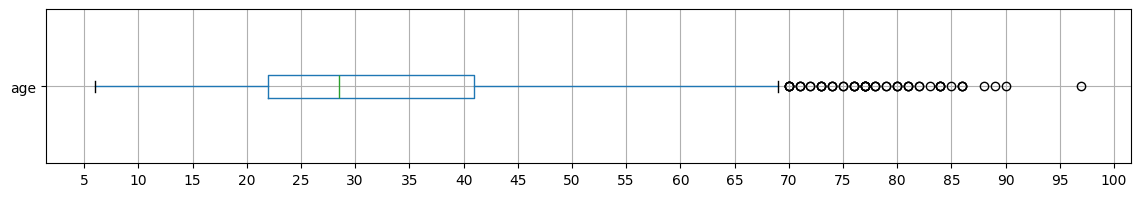

In [256]:
# visualize the ages
plt.figure(figsize=(14, 2))
plt.xticks(ticks=np.arange(0, 101, 5), labels=[str(x) for x in np.arange(0, 101, 5)])
speech_df[speech_df['age'] > 0].boxplot(column=['age'], vert=False)
plt.show()

* What about the age_onset, why does that have 0 values? Do we need to do anything about that? Let's look more closely at the dataset

In [257]:
speech_df[speech_df['age_onset']<1]

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country
363,42.0,0.0,"pittsburgh, pennsylvania, usa",english1,english,male,61,usa
364,35.0,0.0,"davenport, iowa, usa",english10,english,female,62,usa
365,23.0,0.0,"miami, florida, usa",english100,english,female,63,usa
366,18.0,0.0,"toronto, ontario, canada",english101,english,female,64,canada
367,22.0,0.0,"torrington, connecticut, usa",english102,english,male,65,usa
...,...,...,...,...,...,...,...,...
1638,23.0,0.0,"london, england, uk",portuguese40,portuguese,male,1773,uk
1970,0.0,0.0,NaN,synthesized1,synthesized,male,355,NaN
1971,0.0,0.0,NaN,synthesized2,synthesized,female,356,NaN
1972,0.0,0.0,NaN,synthesized3,synthesized,female,357,NaN


In [258]:
speech_df[speech_df['age_onset']<1].native_language.unique()

array(['english', 'portuguese', 'synthesized'], dtype=object)

In [259]:
speech_df[(speech_df['age_onset']<1) & (speech_df['native_language'] == 'portuguese')]

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country
1638,23.0,0.0,"london, england, uk",portuguese40,portuguese,male,1773,uk


* Except synthesized audio entries, and the single person who's native language is Portuguese, all the entries with age_onset of 0 are native English speakers, and thus this represents the group of people who's native language is English.
* If we wish to analyze the speakers' age in which they learned English, we can exclude the native English speakers as there are many of them and are greatly skewing the numbers.

In [260]:
speech_df[speech_df['age_onset']>=1]['age_onset'].describe()

count    1591.000000
mean       12.059082
std         7.654774
min         1.000000
25%         7.000000
50%        11.000000
75%        14.000000
max        86.000000
Name: age_onset, dtype: float64

* Since there are many native languages accounted for, for the sake of good visualization, let's focus on only people who learned English as adults.

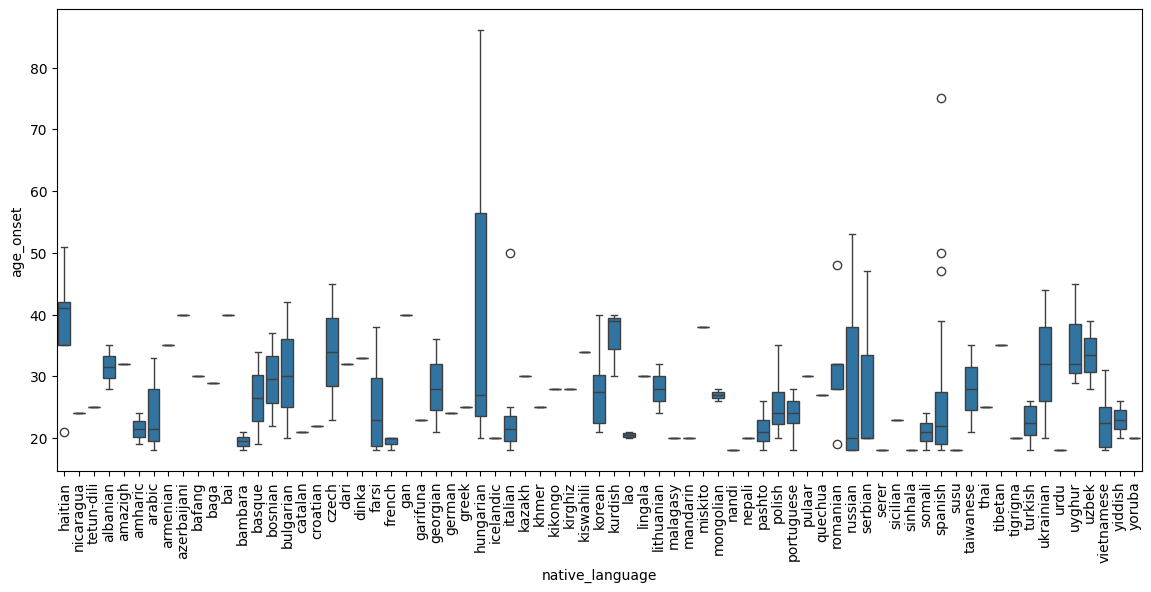

In [261]:
plt.figure(figsize=(14, 6))
plt.xticks(rotation=90)
sns.boxplot(x='native_language', y='age_onset', data=speech_df[speech_df['age_onset']>=18])
plt.show()

## Saving Modified Dataframe

In [262]:
# note that we do not yet need to save the data with pickles since we do not have any complex objects
speech_df.to_csv('data/processed_speakers.csv', sep=',', header=True, index=False, encoding='utf-8')
